# Akash Das (MDS202206)

## Import Required Libraries

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import time
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

### Import Duck and Chicken Images From Google Drive

In [ ]:
# fetching data
!gdown --id 1UFkF9wWkJIS2BvnhCcfLgEbrkh2L3r4j

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1UFkF9wWkJIS2BvnhCcfLgEbrkh2L3r4j
From (redirected): https://drive.google.com/uc?id=1UFkF9wWkJIS2BvnhCcfLgEbrkh2L3r4j&confirm=t&uuid=ff67b065-04d2-4950-931e-9fec30a592be
To: /content/animal_image.zip
100% 30.3M/30.3M [00:00<00:00, 64.8MB/s]


In [ ]:
!unzip /content/animal_image.zip

Archive:  /content/animal_image.zip
   creating: animal_image/test/
   creating: animal_image/test/animal chicken/
  inflating: animal_image/test/animal chicken/0U5DJ4AHL7U8.jpg  
  inflating: animal_image/test/animal chicken/0YRRH5UO983S.jpg  
  inflating: animal_image/test/animal chicken/17ZH2WHTIPL8.jpg  
  inflating: animal_image/test/animal chicken/1O9LZD4GDLEG.jpg  
  inflating: animal_image/test/animal chicken/1OX6JD87ZL6M.jpg  
  inflating: animal_image/test/animal chicken/1WHCYYP4QBBB.jpg  
  inflating: animal_image/test/animal chicken/1ZLB7IELNMCD.jpg  
  inflating: animal_image/test/animal chicken/21AEDSI4YQ9L.jpg  
  inflating: animal_image/test/animal chicken/2GGVG9VUE5VP.jpg  
  inflating: animal_image/test/animal chicken/2IH2F7SXSTFS.jpg  
  inflating: animal_image/test/animal chicken/2MD30734HGEK.jpg  
  inflating: animal_image/test/animal chicken/30XSIDP797YK.jpg  
  inflating: animal_image/test/animal chicken/37ROYA9ANCBW.jpg  
  inflating: animal_image/test/animal ch


### Data augmentation and normalization for training

In [ ]:

# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/animal_image'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
### Let’s visualize a few training images so as to understand the data augmentations.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


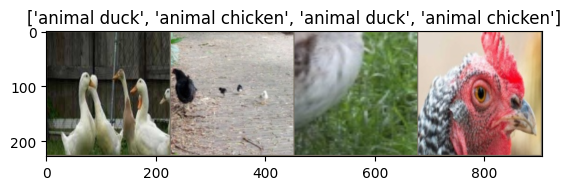

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model
### Now, let’s write a general function to train a model. Here, we will illustrate:

* Scheduling the learning rate

* Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions
Generic function to display predictions for a few images

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the ConvNet
Load a pretrained model and reset final fully connected layer.

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


### Train and evaluate


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5506 Acc: 0.7666
val Loss: 0.3307 Acc: 0.8558

Epoch 1/24
----------
train Loss: 0.6522 Acc: 0.7530
val Loss: 0.9558 Acc: 0.7115

Epoch 2/24
----------
train Loss: 0.6087 Acc: 0.7786
val Loss: 0.3138 Acc: 0.8654

Epoch 3/24
----------
train Loss: 0.4552 Acc: 0.7997
val Loss: 0.2955 Acc: 0.9038

Epoch 4/24
----------
train Loss: 0.4656 Acc: 0.8178
val Loss: 0.2101 Acc: 0.9231

Epoch 5/24
----------
train Loss: 0.4197 Acc: 0.8283
val Loss: 0.2406 Acc: 0.9231

Epoch 6/24
----------
train Loss: 0.4457 Acc: 0.8253
val Loss: 0.2014 Acc: 0.9135

Epoch 7/24
----------
train Loss: 0.3430 Acc: 0.8599
val Loss: 0.1996 Acc: 0.9231

Epoch 8/24
----------
train Loss: 0.3340 Acc: 0.8584
val Loss: 0.1933 Acc: 0.9038

Epoch 9/24
----------
train Loss: 0.3295 Acc: 0.8630
val Loss: 0.1754 Acc: 0.9327

Epoch 10/24
----------
train Loss: 0.2963 Acc: 0.8705
val Loss: 0.1945 Acc: 0.9135

Epoch 11/24
----------
train Loss: 0.2828 Acc: 0.8795
val Loss: 0.1785 Acc: 0.9038

Ep

### Visualize Model Performence

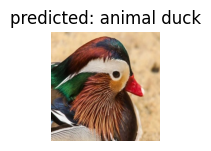

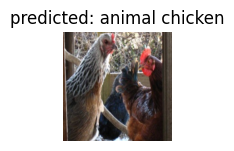

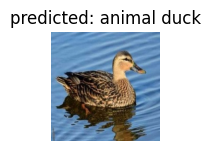

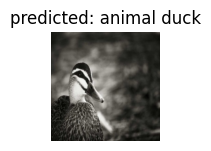

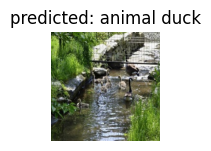

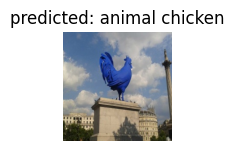

In [ ]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5658 Acc: 0.7169
val Loss: 0.2937 Acc: 0.8558

Epoch 1/24
----------
train Loss: 0.3813 Acc: 0.8389
val Loss: 0.1462 Acc: 0.9327

Epoch 2/24
----------
train Loss: 0.4404 Acc: 0.8298
val Loss: 0.1660 Acc: 0.9423

Epoch 3/24
----------
train Loss: 0.4722 Acc: 0.8193
val Loss: 0.3757 Acc: 0.8654

Epoch 4/24
----------
train Loss: 0.4793 Acc: 0.8042
val Loss: 0.1557 Acc: 0.9231

Epoch 5/24
----------
train Loss: 0.5353 Acc: 0.7846
val Loss: 0.2825 Acc: 0.8942

Epoch 6/24
----------
train Loss: 0.4264 Acc: 0.8133
val Loss: 0.2262 Acc: 0.8942

Epoch 7/24
----------
train Loss: 0.3283 Acc: 0.8449
val Loss: 0.2021 Acc: 0.9135

Epoch 8/24
----------
train Loss: 0.3479 Acc: 0.8389
val Loss: 0.1968 Acc: 0.9231

Epoch 9/24
----------
train Loss: 0.3936 Acc: 0.8298
val Loss: 0.1792 Acc: 0.9135

Epoch 10/24
----------
train Loss: 0.3144 Acc: 0.8509
val Loss: 0.2052 Acc: 0.9135

Epoch 11/24
----------
train Loss: 0.3524 Acc: 0.8328
val Loss: 0.1890 Acc: 0.9135

Ep

###  visualize the predicted class labels along with the images.

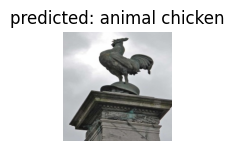

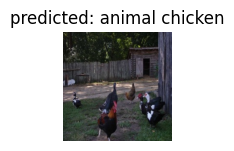

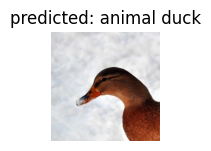

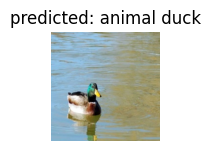

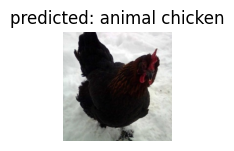

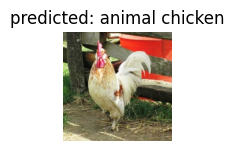

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()